# Airbnb Rio de Janeiro
## listings

dataset: http://insideairbnb.com/get-the-data.html

In [1]:
import pandas as pd
import json

from keplergl import KeplerGl 

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.svm import SVR

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
df_listings = pd.read_csv("data/listings.csv", low_memory=False)
print("Data Shape:", df_listings.shape)
df_listings.head()

Data Shape: (35793, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20200524171540,2020-05-25,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. Please contact ...,"- Beautiful, sunny 2 bedroom (90 square meters...",Discounts for long term stays. Please contact ...,none,This is the one of the bests spots in Rio. Bec...,...,t,f,moderate,f,f,1,1,0,0,2.09
1,21280,https://www.airbnb.com/rooms/21280,20200524171540,2020-05-25,Renovated Modern Apt. Near Beach,Immaculately renovated top-floor apartment ove...,Immaculately renovated top-floor apartment in ...,Immaculately renovated top-floor apartment ove...,none,This is the best neighborhood in Zona Sul. Fo...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.23
2,25026,https://www.airbnb.com/rooms/25026,20200524171540,2020-05-25,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,f,f,strict_14_with_grace_period,t,t,3,3,0,0,1.96
3,31560,https://www.airbnb.com/rooms/31560,20200524171540,2020-05-25,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,2.35
4,35636,https://www.airbnb.com/rooms/35636,20200524171540,2020-05-26,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,2.25


# EDA

## a. Estratégia de modelagem: 

Diante do desafio de prever o preço de uma acomodação, quais elementos mais influenciam na sua precificação ? Hipótese de que os mais importantes sejam:
- Número de quartos
- localização

Através dessas e outras features a serem descobertas, vamos conseguir prever com alguma razoabilidade os valores das acomodações

### Checando colunas e seus tipos

In [4]:
for idx, dtype in zip(df_listings.dtypes.index, df_listings.dtypes):
    print("name:", idx)
    print("type:", dtype)

name: id
type: int64
name: listing_url
type: object
name: scrape_id
type: int64
name: last_scraped
type: object
name: name
type: object
name: summary
type: object
name: space
type: object
name: description
type: object
name: experiences_offered
type: object
name: neighborhood_overview
type: object
name: notes
type: object
name: transit
type: object
name: access
type: object
name: interaction
type: object
name: house_rules
type: object
name: thumbnail_url
type: float64
name: medium_url
type: float64
name: picture_url
type: object
name: xl_picture_url
type: float64
name: host_id
type: int64
name: host_url
type: object
name: host_name
type: object
name: host_since
type: object
name: host_location
type: object
name: host_about
type: object
name: host_response_time
type: object
name: host_response_rate
type: object
name: host_acceptance_rate
type: object
name: host_is_superhost
type: object
name: host_thumbnail_url
type: object
name: host_picture_url
type: object
name: host_neighbourhood
ty

In [5]:
df_listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,35793.0,2.129684e+07,1.368508e+07,1.787800e+04,1.098687e+07,1.704652e+07,3.428384e+07,4.352478e+07
scrape_id,35793.0,2.020052e+13,1.023452e+01,2.020052e+13,2.020052e+13,2.020052e+13,2.020052e+13,2.020052e+13
thumbnail_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xl_picture_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,35793.0,8.492397e+07,8.916201e+07,1.173900e+04,1.508375e+07,5.640055e+07,1.118898e+08,3.468845e+08
host_listings_count,35788.0,1.868129e+01,1.322389e+02,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.379000e+03
host_total_listings_count,35788.0,1.868129e+01,1.322389e+02,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.379000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,35793.0,-2.296522e+01,3.488945e-02,-2.307340e+01,-2.298456e+01,-2.297066e+01,-2.294693e+01,-2.275038e+01


### Feature selection - selecionando algumas colunas mais relevantes arbitrariamente antes de continuar

In [6]:
df_listings = df_listings[['host_listings_count','host_response_rate', 'host_acceptance_rate', 'host_identity_verified', 'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price', 'cleaning_fee', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'availability_90','extra_people', 'security_deposit']]

In [7]:
df_listings.isna().sum()

host_listings_count           5
host_response_rate        19310
host_acceptance_rate      12643
host_identity_verified        5
neighbourhood_cleansed        0
zipcode                    1744
latitude                      0
longitude                     0
property_type                 0
accommodates                  0
bathrooms                    67
bedrooms                     73
beds                        329
square_feet               35329
price                         0
cleaning_fee              11520
guests_included               0
minimum_nights                0
number_of_reviews             0
review_scores_rating      15791
reviews_per_month         14906
availability_90               0
extra_people                  0
security_deposit          15642
dtype: int64

Removendo colunas que não 'valem a pena'

In [8]:
df_listings.drop(columns=['host_response_rate','host_acceptance_rate','square_feet','review_scores_rating','reviews_per_month'], inplace=True)

Abrindo mão de 1749 registros para podermos testar o uso do CEP

In [9]:
df_listings.dropna(subset=['zipcode','host_identity_verified','host_listings_count'], inplace=True)

In [10]:
df_listings.isna().sum()

host_listings_count           0
host_identity_verified        0
neighbourhood_cleansed        0
zipcode                       0
latitude                      0
longitude                     0
property_type                 0
accommodates                  0
bathrooms                    63
bedrooms                     68
beds                        313
price                         0
cleaning_fee              10809
guests_included               0
minimum_nights                0
number_of_reviews             0
availability_90               0
extra_people                  0
security_deposit          14738
dtype: int64

## preprocessa para visualização no mapa interativo

In [11]:
df_listings['price'] = df_listings.price.str.replace('$','')
df_listings['price'] = df_listings.price.str.replace(',','')
df_listings.price = pd.to_numeric(df_listings.price)


df_listings['cleaning_fee'] = df_listings.cleaning_fee.str.replace('$','')
df_listings['cleaning_fee'] = df_listings.cleaning_fee.str.replace(',','')
df_listings.cleaning_fee = pd.to_numeric(df_listings.cleaning_fee)

df_listings.cleaning_fee = df_listings.cleaning_fee.fillna(0)
#df_listings.cleaning_fee = df_listings.cleaning_fee.fillna(df_listings.cleaning_fee.median())

df_listings['extra_people'] = df_listings.extra_people.str.replace('$','')
df_listings['extra_people'] = df_listings.extra_people.str.replace(',','')
df_listings.extra_people = pd.to_numeric(df_listings.extra_people)


df_listings['security_deposit'] = df_listings.security_deposit.str.replace('$','')
df_listings['security_deposit'] = df_listings.security_deposit.str.replace(',','')
df_listings.security_deposit = pd.to_numeric(df_listings.security_deposit)

df_listings.security_deposit = df_listings.security_deposit.fillna(0)


In [12]:
df_listings.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,minimum_nights,number_of_reviews,availability_90,extra_people,security_deposit
count,34044.000000,34044.000000,34044.000000,34044.000000,33981.000000,33976.000000,33731.000000,34044.000000,34044.000000,34044.000000,34044.000000,34044.000000,34044.000000,34044.000000,34044.000000
mean,19.292915,-22.965311,-43.252010,4.186670,1.669948,1.622557,2.543032,797.505728,113.079015,1.743097,4.804518,9.889467,52.501410,42.747709,677.653889
std,134.722293,0.034608,0.096543,2.627903,1.041778,1.085454,2.079550,2476.174253,181.273934,1.612901,22.095723,26.000473,41.569926,111.839453,2243.821311
min,0.000000,-23.073400,-43.737090,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-22.984530,-43.320130,2.000000,1.000000,1.000000,1.000000,159.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,-22.970730,-43.198645,4.000000,1.000000,1.000000,2.000000,299.000000,100.000000,1.000000,2.000000,1.000000,83.000000,0.000000,0.000000
75%,3.000000,-22.947508,-43.186600,5.000000,2.000000,2.000000,3.000000,649.000000,160.000000,2.000000,4.000000,6.000000,89.000000,50.000000,500.000000
max,1379.000000,-22.750380,-43.104620,160.000000,20.000000,30.000000,62.000000,138288.000000,7743.000000,36.000000,1123.000000,401.000000,90.000000,5631.000000,82957.000000


## Visualiza distribuição espacial

In [13]:
with open('mapconfig.json') as json_file:
    map_config = json.load(json_file)

In [14]:
map_1 = KeplerGl(height=500, config=map_config)
map_1.add_data(data=df_listings, name="data_1")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


## Valor por região

Cor dos hexágonos = valor médio da diária na região

In [15]:
map_1

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '6cu8gy', 'type': '…

## Checa distribuição por vizinhanças

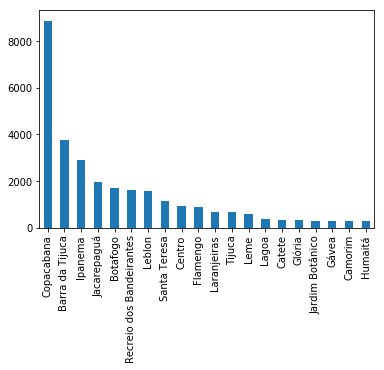

In [16]:
df_listings.neighbourhood_cleansed.value_counts()[:20].plot.bar();

## Checa distribuições numéricas

In [17]:
df_listings.shape

(34044, 19)

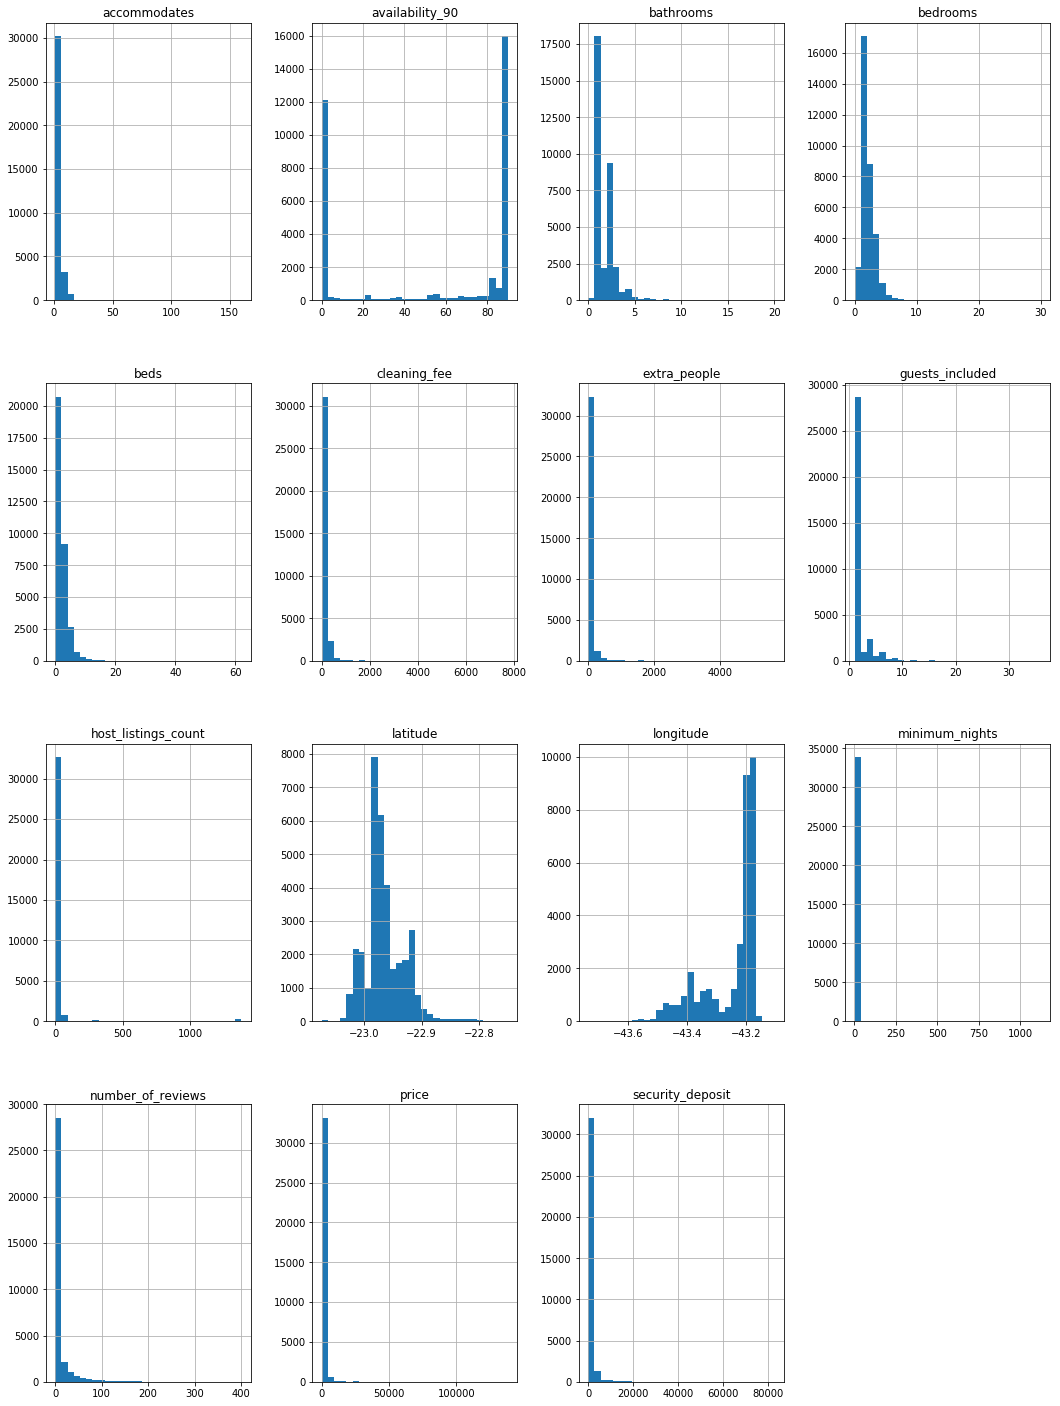

In [18]:
df_listings.hist(bins=30,figsize=(18,25));

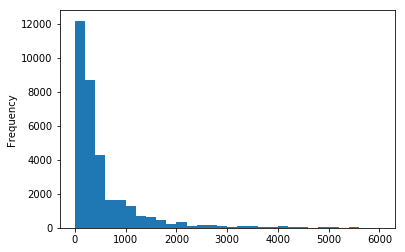

In [19]:
df_listings[df_listings.price < 6000].price.plot.hist(bins=30);

- Distribuição das features numéricas é exponencial
- Alguns outliers 'impactando' no comportamento do dataset

## Pré-processa / filtra outliers / imputation

### Filtrando datapoints até o terceiro quartil + uma quantidade arbitrária

In [20]:
df_listings = df_listings[df_listings.accommodates < 20]
df_listings.shape

(34038, 19)

In [21]:
df_listings = df_listings[df_listings.bathrooms < 10]
df_listings.shape

(33958, 19)

In [22]:
df_listings = df_listings[df_listings.bedrooms < 10]
df_listings.shape

(33882, 19)

In [23]:
df_listings = df_listings[df_listings.beds < 10]
df_listings.shape

(33266, 19)

In [24]:
df_listings = df_listings[df_listings.guests_included < 10]
df_listings.shape

(33096, 19)

In [25]:
df_listings = df_listings[df_listings.minimum_nights <= 60]
df_listings.shape

(32944, 19)

In [26]:
df_listings = df_listings[df_listings.price <= 2000]
df_listings.shape

(30823, 19)

In [27]:
df_listings = df_listings[df_listings.cleaning_fee <= 1000]
df_listings.shape

(30770, 19)

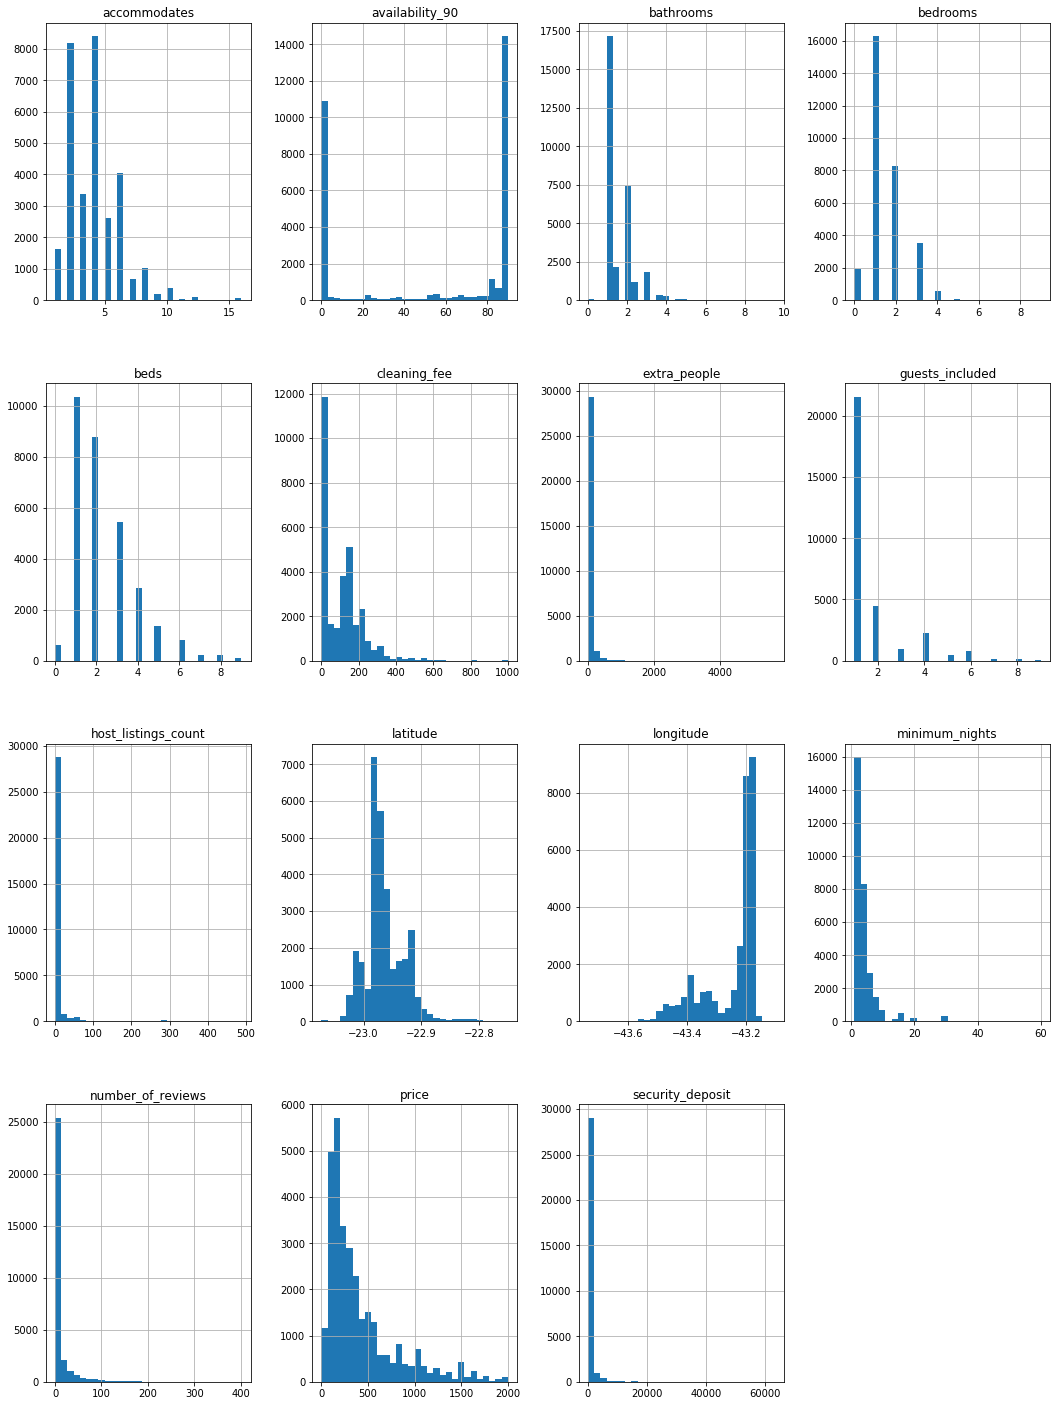

In [28]:
df_listings.hist(bins=30,figsize=(18,25));

Muito melhor!

### Transforma zipcode em feature numérica para avaliação 

In [29]:
df_listings['zipcode'] = df_listings['zipcode'].str.replace(r"[a-zA-Z]",'')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('•','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('-','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace(',','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace(' ','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('\n','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('.','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('/','')
df_listings['zipcode'] = df_listings['zipcode'].str.replace('_','')

df_listings['zipcode'] = pd.to_numeric(df_listings['zipcode'])

In [30]:
df_listings.dropna(subset=['zipcode'], inplace=True)
df_listings.isna().sum()

host_listings_count       0
host_identity_verified    0
neighbourhood_cleansed    0
zipcode                   0
latitude                  0
longitude                 0
property_type             0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
price                     0
cleaning_fee              0
guests_included           0
minimum_nights            0
number_of_reviews         0
availability_90           0
extra_people              0
security_deposit          0
dtype: int64

### Filtrando datapoints somente dos bairros com mais de 100 listings

In [31]:
value_counts = df_listings.neighbourhood_cleansed.value_counts() > 100
top_neighborhoods = value_counts[value_counts.values].index.values
top_neighborhoods

array(['Copacabana', 'Barra da Tijuca', 'Ipanema', 'Jacarepaguá',
       'Botafogo', 'Recreio dos Bandeirantes', 'Leblon', 'Santa Teresa',
       'Centro', 'Flamengo', 'Laranjeiras', 'Tijuca', 'Leme', 'Lagoa',
       'Glória', 'Catete', 'Humaitá', 'Camorim', 'Jardim Botânico',
       'Gávea', 'Maracanã', 'Vila Isabel', 'Freguesia (Jacarepaguá)',
       'Taquara', 'São Conrado', 'Vargem Pequena', 'Vidigal', 'Urca',
       'Itanhangá', 'Cosme Velho', 'Rio Comprido'], dtype=object)

In [32]:
df_listings = df_listings[df_listings.neighbourhood_cleansed.isin(top_neighborhoods)]
df_listings.shape

(28567, 19)

### Filtrando datapoints dos tipos de propriedade com mais de 50 listings

In [33]:
value_counts = df_listings.property_type.value_counts() > 50
top_property_types = value_counts[value_counts.values].index.values
top_property_types

array(['Apartment', 'House', 'Condominium', 'Loft', 'Serviced apartment',
       'Guest suite', 'Bed and breakfast', 'Guesthouse', 'Hotel', 'Villa',
       'Hostel', 'Other'], dtype=object)

In [34]:
df_listings = df_listings[df_listings.property_type.isin(top_property_types)]
df_listings.shape

(28375, 19)

### Faz one hot com alguns campos

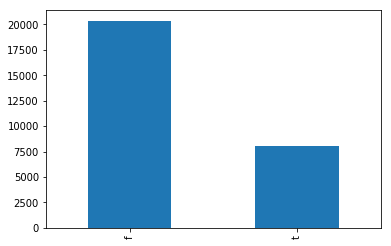

In [35]:
df_listings.host_identity_verified.value_counts().plot.bar();

In [36]:
## pequeno hack para podermos continuar os testes antes dos one_hots
df_listings2 = df_listings.copy()

In [37]:
one_hot = pd.get_dummies(df_listings['host_identity_verified'], prefix="host_identity_verified")
df_listings = df_listings.join(one_hot)

df_listings = df_listings.drop(['host_identity_verified'], axis=1)

print(df_listings.shape)
df_listings.head()

(28375, 20)


,host_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,minimum_nights,number_of_reviews,availability_90,extra_people,security_deposit,host_identity_verified_f,host_identity_verified_t
0,2.0,Copacabana,22020050.0,-22.96592,-43.17896,Condominium,5,1.0,2.0,2.0,188.0,250.0,2,7,251,83,0.0,0.0,0,1
1,0.0,Ipanema,22420010.0,-22.98467,-43.19611,Apartment,6,2.0,2.0,4.0,442.0,277.0,6,5,94,90,0.0,2765.0,0,1
2,3.0,Copacabana,22060020.0,-22.97712,-43.19045,Apartment,2,1.0,1.0,2.0,160.0,250.0,2,7,238,0,45.0,1000.0,0,1
3,1.0,Ipanema,22410003.0,-22.98302,-43.21427,Apartment,3,1.0,1.0,1.0,359.0,111.0,2,2,282,0,55.0,0.0,0,1
4,1.0,Ipanema,22081020.0,-22.98816,-43.19359,Apartment,2,1.5,1.0,1.0,495.0,225.0,2,2,181,89,0.0,1375.0,0,1


In [38]:
one_hot = pd.get_dummies(df_listings['neighbourhood_cleansed'], prefix="neighbourhood")
df_listings = df_listings.join(one_hot)

df_listings = df_listings.drop(['neighbourhood_cleansed'], axis=1)

print(df_listings.shape)
df_listings.head()

(28375, 50)


,host_listings_count,zipcode,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,...,neighbourhood_Recreio dos Bandeirantes,neighbourhood_Rio Comprido,neighbourhood_Santa Teresa,neighbourhood_São Conrado,neighbourhood_Taquara,neighbourhood_Tijuca,neighbourhood_Urca,neighbourhood_Vargem Pequena,neighbourhood_Vidigal,neighbourhood_Vila Isabel
0,2.0,22020050.0,-22.96592,-43.17896,Condominium,5,1.0,2.0,2.0,188.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,22420010.0,-22.98467,-43.19611,Apartment,6,2.0,2.0,4.0,442.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,22060020.0,-22.97712,-43.19045,Apartment,2,1.0,1.0,2.0,160.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,22410003.0,-22.98302,-43.21427,Apartment,3,1.0,1.0,1.0,359.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,22081020.0,-22.98816,-43.19359,Apartment,2,1.5,1.0,1.0,495.0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
one_hot = pd.get_dummies(df_listings['property_type'], prefix="property_type")
df_listings = df_listings.join(one_hot)

df_listings = df_listings.drop(['property_type'], axis=1)

print(df_listings.shape)
df_listings.head()

(28375, 61)


,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,...,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Villa
0,2.0,22020050.0,-22.96592,-43.17896,5,1.0,2.0,2.0,188.0,250.0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,22420010.0,-22.98467,-43.19611,6,2.0,2.0,4.0,442.0,277.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,22060020.0,-22.97712,-43.19045,2,1.0,1.0,2.0,160.0,250.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,22410003.0,-22.98302,-43.21427,3,1.0,1.0,1.0,359.0,111.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,22081020.0,-22.98816,-43.19359,2,1.5,1.0,1.0,495.0,225.0,...,0,0,0,0,0,0,0,0,0,0


## processa latlong para funcionar com 'aproximação'

In [40]:
# df_listings.latitude = df_listings.latitude.round(3)
# df_listings.longitude = df_listings.longitude.round(3)

## Checa alguns modelos

In [41]:
X = df_listings.drop(['price'],axis=1)
y = df_listings['price']
X.shape, y.shape

((28375, 60), (28375,))

In [42]:
import warnings
warnings.filterwarnings('ignore')

regressores = []
regressores.append(RandomForestRegressor())
regressores.append(xgb.XGBRegressor(objective ='reg:squarederror'))
regressores.append(AdaBoostRegressor())
regressores.append(SVR())


df_results = pd.DataFrame()
for regressor in regressores:
    
    regressor_name = regressor.__class__.__name__
    
    print(f"Resultados de {regressor_name}:" )
    
    results = cross_val_score(regressor, X, y, cv=5, scoring='neg_root_mean_squared_error')
    
    df_result = pd.DataFrame([results], columns = ['fold1','fold2','fold3','fold4', 'fold5'], index = [regressor_name])
    df_results = pd.concat([df_results, df_result])
    print(results)
    
print("Métrica: neg_root_mean_squared_error")

Resultados de RandomForestRegressor:
[-294.92250125 -344.56361818 -259.82221057 -223.77730267 -279.34611486]
Resultados de XGBRegressor:
[-292.80975782 -345.56474965 -255.99643285 -220.80492559 -260.04276436]
Resultados de AdaBoostRegressor:
[-320.07425687 -364.05350043 -350.29096941 -312.7133028  -354.78057805]
Resultados de SVR:
[-438.61888671 -569.77375604 -362.79313107 -284.25601464 -318.67378217]
Métrica: neg_root_mean_squared_error


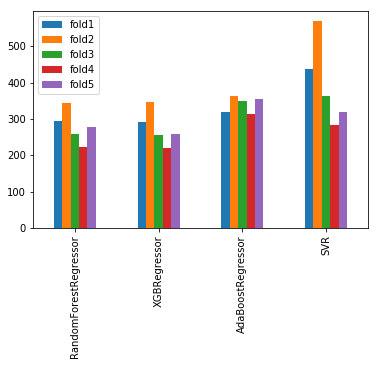

In [43]:
df_results *= -1
df_results.plot.bar();

## b. Função Custo

Função custo usada nessa análise foi um mix de MSE e RMSE, o RMSE é usado pra dar uma noção mais aproximada da diferença entre o 'chute' e o valor real da acomodação.

Não comparei com RAE ou RSE por questão de tempo, vale a pena experimentar também com essas métrias

## c. Modelos escolhidos:
- Random Forest
- XG Boost

Critério para seleção dos modelos: menor RMSE nos primeiros testes (com hiperparâmetros default)

## Separa dataset para avaliação dos modelos

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22700, 60), (5675, 60), (22700,), (5675,))

### Funções utilitárias

In [45]:
def fit_validate(regressor, X_train, X_test, y_train, y_test):
    regressor.fit(X_train, y_train)
    train_predict = regressor.predict(X_train)
    test_predict = regressor.predict(X_test)
    
    mse_train = mean_squared_error(y_train, train_predict)
    mse_test = mean_squared_error(y_test, test_predict)
    
    rmse_train = math.sqrt(mse_train)
    rmse_test = math.sqrt(mse_test)
    
    r2_train = r2_score(y_train, train_predict)
    r2_test = r2_score(y_test, test_predict)
    
    print("MSE Train: %.2f" % mse_train)
    print("MSE Test: %.2f"  % mse_test)
    print("RMSE Train: %.2f" % rmse_train)
    print("RMSE Test: %.2f"  % rmse_test)
    print('R2 Train: %.2f' % r2_train)
    print('R2 Test: %.2f' % r2_test)
    
    df_rmse = pd.DataFrame([rmse_train,rmse_test], columns=['RMSE'], index=['train','test'])
    df_rmse.plot.bar()

In [46]:
def plot_feature_importances(regressor, X_train, is_forest=False):
    importances = regressor.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    if(is_forest):
        std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
                     axis=0)
        std = std[indices]
    else:
        std= None
        
    

    #Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):

        print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std, align="center")
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [47]:
def plot_predicted_vs_true_label(regressor, X_train, X_test, y_train, y_test):
    y_test_pred = regressor.predict(X_test)
    y_train_pred = regressor.predict(X_train)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)

    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,2000)), list(range(2,2000)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')

    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,2000)), list(range(2,2000)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')

    plt.show()

## Random Forest

MSE Train: 10232.46
MSE Test: 73650.62
RMSE Train: 101.16
RMSE Test: 271.39
R2 Train: 0.93
R2 Test: 0.50


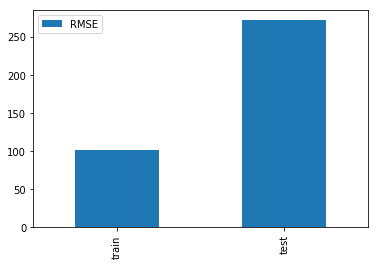

In [48]:
reg = RandomForestRegressor() 

fit_validate(reg, X_train, X_test, y_train, y_test)

Feature ranking:
1. feature bedrooms (0.212801)
2. feature number_of_reviews (0.121938)
3. feature latitude (0.084559)
4. feature longitude (0.073864)
5. feature cleaning_fee (0.063872)
6. feature zipcode (0.060843)
7. feature bathrooms (0.051340)
8. feature extra_people (0.048493)
9. feature minimum_nights (0.046227)
10. feature security_deposit (0.041695)
11. feature accommodates (0.036189)
12. feature host_listings_count (0.030790)
13. feature availability_90 (0.027990)
14. feature beds (0.023654)
15. feature guests_included (0.010725)
16. feature property_type_Apartment (0.006078)
17. feature neighbourhood_Leblon (0.005423)
18. feature neighbourhood_Ipanema (0.004568)
19. feature neighbourhood_Barra da Tijuca (0.004019)
20. feature host_identity_verified_f (0.003737)
21. feature neighbourhood_Copacabana (0.003570)
22. feature host_identity_verified_t (0.003436)
23. feature property_type_Condominium (0.002994)
24. feature neighbourhood_Jacarepaguá (0.002671)
25. feature property_typ

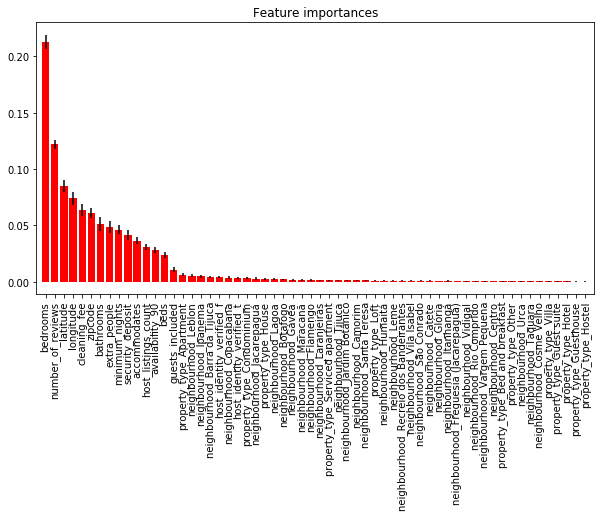

In [49]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_feature_importances(reg, X_train, is_forest=True)

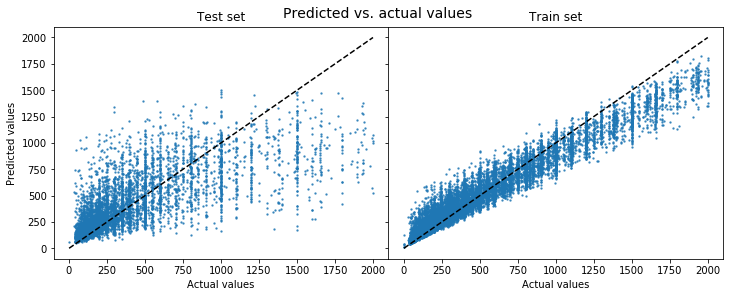

In [50]:
plot_predicted_vs_true_label(reg, X_train, X_test, y_train, y_test)

## Segundo round, após remoção de features irrelevantes

In [51]:
df_listings2 = df_listings2.drop(columns=['host_identity_verified','neighbourhood_cleansed','property_type'])
df_listings2.head()

,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,minimum_nights,number_of_reviews,availability_90,extra_people,security_deposit
0,2.0,22020050.0,-22.96592,-43.17896,5,1.0,2.0,2.0,188.0,250.0,2,7,251,83,0.0,0.0
1,0.0,22420010.0,-22.98467,-43.19611,6,2.0,2.0,4.0,442.0,277.0,6,5,94,90,0.0,2765.0
2,3.0,22060020.0,-22.97712,-43.19045,2,1.0,1.0,2.0,160.0,250.0,2,7,238,0,45.0,1000.0
3,1.0,22410003.0,-22.98302,-43.21427,3,1.0,1.0,1.0,359.0,111.0,2,2,282,0,55.0,0.0
4,1.0,22081020.0,-22.98816,-43.19359,2,1.5,1.0,1.0,495.0,225.0,2,2,181,89,0.0,1375.0


### Checa correlação entre variáveis

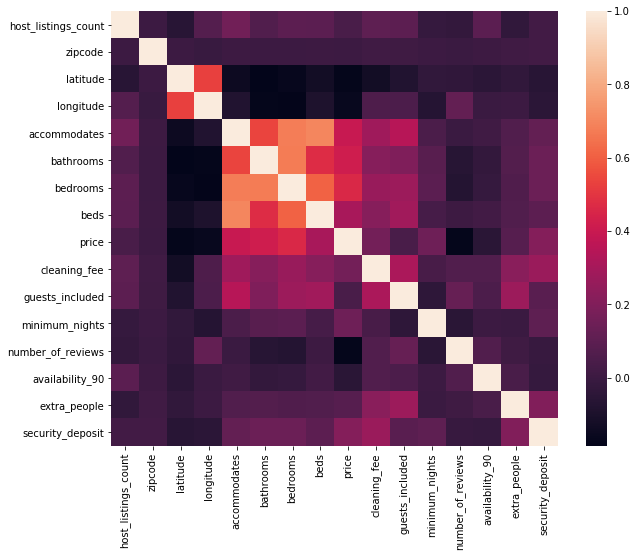

In [52]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_listings2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool))
plt.show()

In [53]:
X = df_listings2.drop(['price'],axis=1)
y = df_listings2['price']
X.shape, y.shape

((28375, 15), (28375,))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25537, 15), (2838, 15), (25537,), (2838,))

MSE Train: 9908.92
MSE Test: 75778.86
RMSE Train: 99.54
RMSE Test: 275.28
R2 Train: 0.93
R2 Test: 0.51


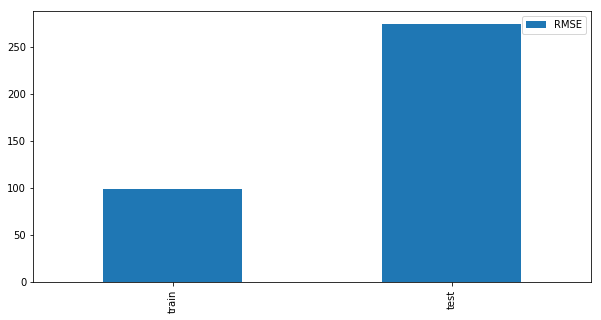

In [76]:
reg = RandomForestRegressor(n_estimators=400, n_jobs=6) 

fit_validate(reg, X_train, X_test, y_train, y_test)

Feature ranking:
1. feature bedrooms (0.215664)
2. feature number_of_reviews (0.123079)
3. feature latitude (0.097725)
4. feature longitude (0.089049)
5. feature zipcode (0.071718)
6. feature cleaning_fee (0.067213)
7. feature bathrooms (0.052662)
8. feature minimum_nights (0.048800)
9. feature extra_people (0.048253)
10. feature security_deposit (0.043698)
11. feature accommodates (0.038994)
12. feature host_listings_count (0.034614)
13. feature availability_90 (0.030176)
14. feature beds (0.026211)
15. feature guests_included (0.012144)


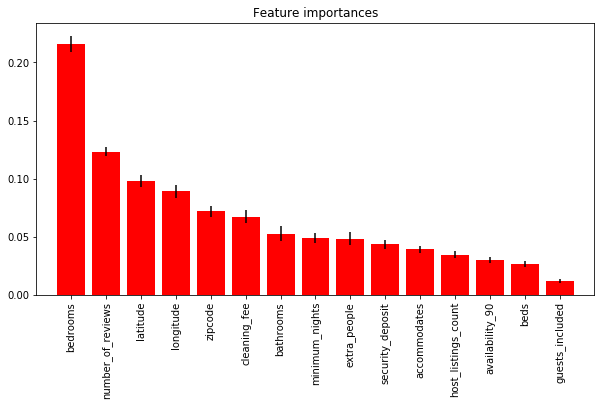

In [77]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_feature_importances(reg, X_train, is_forest=True)

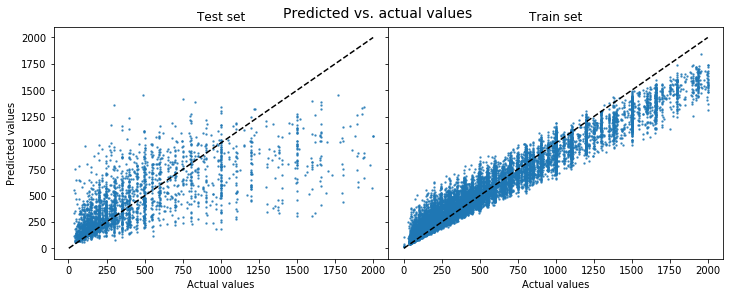

In [78]:
plot_predicted_vs_true_label(reg, X_train, X_test, y_train, y_test)

## XG Boost

In [127]:
from sklearn.model_selection import GridSearchCV


parameters = {
    'n_estimators':(100,500,1500,2000),
    'eta':[0.1, 0.2, 0.3],
    'num_parallel_tree':[2,4],
    'max_depth':[4,6,8]
}

# testando.
clf_GridSearch = GridSearchCV(xgb_reg, parameters, verbose=2, cv=4)
clf_GridSearch.fit(X, y)

# melhores valores de parêmetro determinando o melhor modelo
clf_best = clf_GridSearch.best_estimator_
print("O melhor modelo é:")
print(clf_best)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2 .....
[08:00:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2, total=   2.5s
[CV] eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2 .....
[08:00:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2, total=   2.4s
[CV] eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2 .....
[08:01:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2, total=   2.5s
[CV] eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2 .....
[08:01:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=2, total=   2.6s
[CV] eta=0.1, max_depth=4, n_estimators=100, num_parallel_tree=4 .....
[08:01:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[CV]  eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=2, total=  47.7s
[CV] eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=2 ....
[08:13:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=2, total=  46.5s
[CV] eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=4 ....
[08:13:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=4, total= 1.5min
[CV] eta=0.1, max_depth=4, n_estimators=2000, num_parallel_tree=4 ....
[08:15:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[CV]  eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=2, total=  56.3s
[CV] eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=4 ....
[08:28:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=4, total= 1.9min
[CV] eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=4 ....
[08:30:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=4, total= 1.9min
[CV] eta=0.1, max_depth=6, n_estimators=1500, num_parallel_tree=4 ....
[08:32:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[CV]  eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4, total= 1.1min
[CV] eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4 .....
[08:55:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4, total=  56.0s
[CV] eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4 .....
[08:56:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4, total=  55.9s
[CV] eta=0.1, max_depth=8, n_estimators=500, num_parallel_tree=4 .....
[08:57:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[CV]  eta=0.2, max_depth=4, n_estimators=100, num_parallel_tree=4, total=   4.5s
[CV] eta=0.2, max_depth=4, n_estimators=100, num_parallel_tree=4 .....
[09:38:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=4, n_estimators=100, num_parallel_tree=4, total=   5.5s
[CV] eta=0.2, max_depth=4, n_estimators=100, num_parallel_tree=4 .....
[09:38:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=4, n_estimators=100, num_parallel_tree=4, total=   5.8s
[CV] eta=0.2, max_depth=4, n_estimators=500, num_parallel_tree=2 .....
[09:38:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[CV]  eta=0.2, max_depth=4, n_estimators=2000, num_parallel_tree=4, total= 1.6min
[CV] eta=0.2, max_depth=4, n_estimators=2000, num_parallel_tree=4 ....
[09:56:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=4, n_estimators=2000, num_parallel_tree=4, total= 1.5min
[CV] eta=0.2, max_depth=6, n_estimators=100, num_parallel_tree=2 .....
[09:57:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=6, n_estimators=100, num_parallel_tree=2, total=   4.6s
[CV] eta=0.2, max_depth=6, n_estimators=100, num_parallel_tree=2 .....
[09:57:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[CV]  eta=0.2, max_depth=6, n_estimators=1500, num_parallel_tree=4, total= 1.9min
[CV] eta=0.2, max_depth=6, n_estimators=2000, num_parallel_tree=2 ....
[10:14:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=6, n_estimators=2000, num_parallel_tree=2, total= 1.3min
[CV] eta=0.2, max_depth=6, n_estimators=2000, num_parallel_tree=2 ....
[10:15:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=6, n_estimators=2000, num_parallel_tree=2, total= 1.3min
[CV] eta=0.2, max_depth=6, n_estimators=2000, num_parallel_tree=2 ....
[10:16:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[CV]  eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2, total= 1.6min
[CV] eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2 ....
[10:38:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2, total= 1.5min
[CV] eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2 ....
[10:39:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2, total= 1.5min
[CV] eta=0.2, max_depth=8, n_estimators=1500, num_parallel_tree=2 ....
[10:41:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[CV]  eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=2, total=  11.9s
[CV] eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=2 .....
[11:16:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=2, total=  12.0s
[CV] eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=2 .....
[11:17:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=2, total=  12.1s
[CV] eta=0.3, max_depth=4, n_estimators=500, num_parallel_tree=4 .....
[11:17:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[CV]  eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=2, total=   4.5s
[CV] eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=2 .....
[11:34:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=2, total=   4.6s
[CV] eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=4 .....
[11:35:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=4, total=   8.2s
[CV] eta=0.3, max_depth=6, n_estimators=100, num_parallel_tree=4 .....
[11:35:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[CV]  eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=2, total= 1.2min
[CV] eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=4 ....
[11:55:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=4, total= 2.5min
[CV] eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=4 ....
[11:58:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=4, total= 2.5min
[CV] eta=0.3, max_depth=6, n_estimators=2000, num_parallel_tree=4 ....
[12:00:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[CV]  eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4, total= 2.9min
[CV] eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4 ....
[12:20:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4, total= 3.1min
[CV] eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4 ....
[12:23:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4, total= 3.4min
[CV] eta=0.3, max_depth=8, n_estimators=1500, num_parallel_tree=4 ....
[12:27:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 292.0min finished


O melhor modelo é:
XGBRegressor(eta=0.1, max_depth=6, num_parallel_tree=2)


[13:24:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE Train: 51674.85
MSE Test: 70896.45
RMSE Train: 227.32
RMSE Test: 266.26
R2 Train: 0.64
R2 Test: 0.54


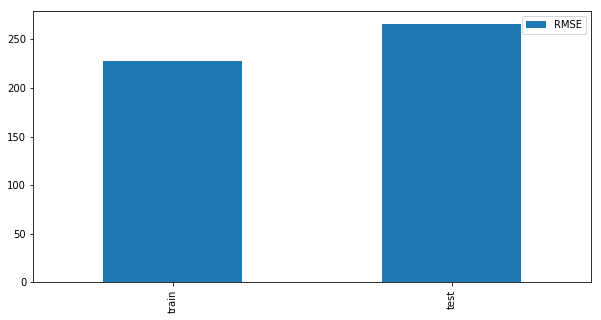

In [128]:


## Testes que deram errado
#xgb_reg = xgb.XGBRegressor(eta=0.1, max_depth=12, num_parallel_tree=4, n_estimators=100)
#xgb_reg = xgb.XGBRegressor(eta=0.1, num_parallel_tree=4)
#xgb_reg = xgb.XGBRegressor()
#xgb_reg = xgb.XGBRegressor(n_estimators=2000)
#xgb_reg = xgb.XGBRegressor(n_estimators=2000, eta=0.1, num_parallel_tree=4)
#xgb_reg = xgb.XGBRegressor(n_estimators=2000, eta=0.1, num_parallel_tree=4, max_depth=8)

## Melhor estimador, de acordo com o experimento com gridsearch + CV
xgb_reg = xgb.XGBRegressor(eta=0.1, max_depth=6, num_parallel_tree=2)

fit_validate(xgb_reg, X_train, X_test, y_train, y_test)

Feature ranking:
1. feature bedrooms (0.432528)
2. feature number_of_reviews (0.146059)
3. feature bathrooms (0.100587)
4. feature extra_people (0.049500)
5. feature cleaning_fee (0.046987)
6. feature accommodates (0.038903)
7. feature minimum_nights (0.036237)
8. feature security_deposit (0.035964)
9. feature latitude (0.020776)
10. feature host_listings_count (0.018999)
11. feature longitude (0.017420)
12. feature guests_included (0.016377)
13. feature availability_90 (0.014981)
14. feature zipcode (0.013504)
15. feature beds (0.011176)


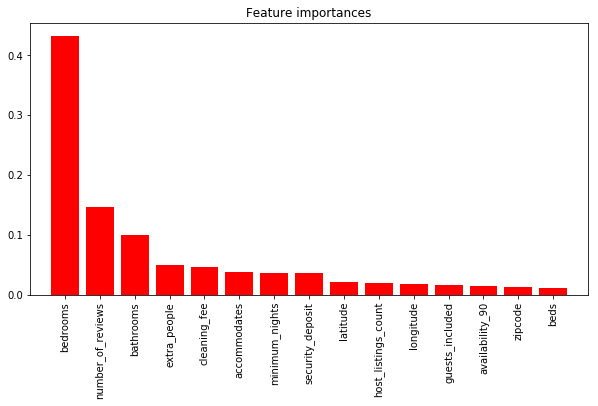

In [129]:
plot_feature_importances(xgb_reg, X_train, is_forest=False)

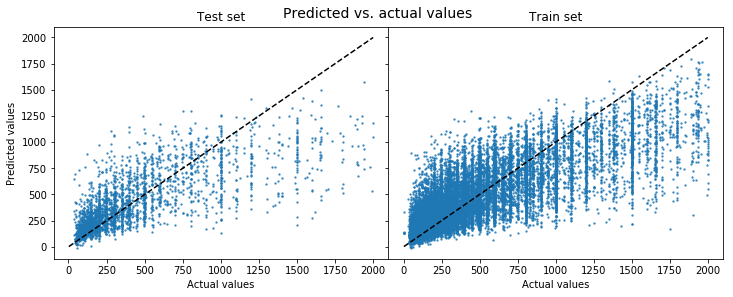

In [130]:
plot_predicted_vs_true_label(xgb_reg, X_train, X_test, y_train, y_test)

## c. Modelo final escolhido
XGBoost foi o melhor modelo para esse desafio, apesar de ele possuir resultados muito similares aos da RandomForest no test set,  o modelo claramente está menos overfitado. É possível observar isso pela diferença do RMSE e do R2 entre train e test de ambos os modelos.

Além disso também é notável o overfit da random forest no trainset através da dispersão dos valores previstos e dos valores reais


## d. Critério para validação do modelo

Usei uma combinação de:
1. coeficiente de determinação (que na verdade nos mostra que o modelo não está conseguindo explicar bem o valor com as features que ele possui)
2. RMSE (que nos demostra a distância das previsões do modelo com os valores reais
3. Dispersão dos valores: Achei interessante trazer, além das métricas, uma alternativa visual para checarmos pontualmente de que maneira o modelo está acertando ou errando em seus chutes

## e. Evidências de que o modelo é suficientemente bom:

Não há evidências que o modelo é suficientemente bom para alguma aplicação em produção de imediato.

Melhorias necessárias ao modelo:

1. Busca por outras features que possam ajudar na previsão do preço
2. Ciclo de tunagem de hiperparâmetros
3. benchmarks com outros modelos para comparação de resultados
4. experimentos com DNNs, a fim de checar se a complexidade do dataset pode ser melhor explicada por um modelo mais complexo

## Observações finais:

Após a variação dos valores das acomodações (foram testados acomodações com valores abaixo de 2000 e em seguida abaixo de 8000 para treino dos modelos), novas features tomaram relevância e percebemos um aumento do r2 até 0.6. Apesar disso, os novos valores também ampliaram o range de chutes dos modelos, aumentando consequentemente o RMSE.

Por essa razão, optei por manter o treinamento do modelo somente para acomodações abaixo de 2000 reais, de forma que o modelo não generalizará bem para acomodações de luxo, mas no geral performará bem.